In [48]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [49]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [50]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [51]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [52]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [53]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [54]:
for epoch in range(1, 60):
    train(epoch)
    test()

/home/aditya/.local/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 545.618906
Train Epoch: 1 [10000/60000 (17%)]	Loss: 193.564727
Train Epoch: 1 [20000/60000 (33%)]	Loss: 181.350332
Train Epoch: 1 [30000/60000 (50%)]	Loss: 175.072168
Train Epoch: 1 [40000/60000 (67%)]	Loss: 167.108418
Train Epoch: 1 [50000/60000 (83%)]	Loss: 174.100957
====> Epoch: 1 Average loss: 179.5068
====> Test set loss: 162.9129
Train Epoch: 2 [0/60000 (0%)]	Loss: 156.578086
Train Epoch: 2 [10000/60000 (17%)]	Loss: 171.835449
Train Epoch: 2 [20000/60000 (33%)]	Loss: 165.228262
Train Epoch: 2 [30000/60000 (50%)]	Loss: 161.014375
Train Epoch: 2 [40000/60000 (67%)]	Loss: 154.270518
Train Epoch: 2 [50000/60000 (83%)]	Loss: 161.975313
====> Epoch: 2 Average loss: 158.8696
====> Test set loss: 154.9320
Train Epoch: 3 [0/60000 (0%)]	Loss: 151.711094
Train Epoch: 3 [10000/60000 (17%)]	Loss: 146.903174
Train Epoch: 3 [20000/60000 (33%)]	Loss: 153.335605
Train Epoch: 3 [30000/60000 (50%)]	Loss: 153.105293
Train Epoch: 3 [40000/60000 (67%)]	Loss: 163.00

Train Epoch: 22 [50000/60000 (83%)]	Loss: 133.208867
====> Epoch: 22 Average loss: 138.7666
====> Test set loss: 139.7242
Train Epoch: 23 [0/60000 (0%)]	Loss: 140.947188
Train Epoch: 23 [10000/60000 (17%)]	Loss: 142.203750
Train Epoch: 23 [20000/60000 (33%)]	Loss: 140.995986
Train Epoch: 23 [30000/60000 (50%)]	Loss: 141.975352
Train Epoch: 23 [40000/60000 (67%)]	Loss: 138.009199
Train Epoch: 23 [50000/60000 (83%)]	Loss: 136.387490
====> Epoch: 23 Average loss: 138.6671
====> Test set loss: 140.1084
Train Epoch: 24 [0/60000 (0%)]	Loss: 139.250117
Train Epoch: 24 [10000/60000 (17%)]	Loss: 140.284941
Train Epoch: 24 [20000/60000 (33%)]	Loss: 147.514004
Train Epoch: 24 [30000/60000 (50%)]	Loss: 130.972891
Train Epoch: 24 [40000/60000 (67%)]	Loss: 139.271113
Train Epoch: 24 [50000/60000 (83%)]	Loss: 148.385205
====> Epoch: 24 Average loss: 138.4702
====> Test set loss: 139.5886
Train Epoch: 25 [0/60000 (0%)]	Loss: 133.363994
Train Epoch: 25 [10000/60000 (17%)]	Loss: 146.980264
Train Epoch: 

Train Epoch: 44 [20000/60000 (33%)]	Loss: 133.567744
Train Epoch: 44 [30000/60000 (50%)]	Loss: 140.618955
Train Epoch: 44 [40000/60000 (67%)]	Loss: 132.552402
Train Epoch: 44 [50000/60000 (83%)]	Loss: 139.166973
====> Epoch: 44 Average loss: 135.3040
====> Test set loss: 138.6835
Train Epoch: 45 [0/60000 (0%)]	Loss: 138.505400
Train Epoch: 45 [10000/60000 (17%)]	Loss: 145.189893
Train Epoch: 45 [20000/60000 (33%)]	Loss: 130.010098
Train Epoch: 45 [30000/60000 (50%)]	Loss: 133.274580
Train Epoch: 45 [40000/60000 (67%)]	Loss: 133.601074
Train Epoch: 45 [50000/60000 (83%)]	Loss: 136.498408
====> Epoch: 45 Average loss: 135.2475
====> Test set loss: 137.9154
Train Epoch: 46 [0/60000 (0%)]	Loss: 132.352676
Train Epoch: 46 [10000/60000 (17%)]	Loss: 139.196465
Train Epoch: 46 [20000/60000 (33%)]	Loss: 133.903467
Train Epoch: 46 [30000/60000 (50%)]	Loss: 137.755762
Train Epoch: 46 [40000/60000 (67%)]	Loss: 138.149258
Train Epoch: 46 [50000/60000 (83%)]	Loss: 137.008906
====> Epoch: 46 Average 

In [55]:
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = ae.decoder(z)
    
    save_image(sample.view(64, 1, 28, 28), './samples/sample_vae1' + '.png')

In [56]:
import numpy as np
import matplotlib.pyplot as plt

In [57]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(train_dataset)), n_to_show)


In [58]:
final_points=np.array([[0,0]])

In [59]:
labels=np.array([0])

In [60]:
for i in example_idx:
    example_images,example_labels =train_dataset[i]
    example_images=example_images.view(-1,784)
    mu,log_var = vae.encoder(example_images)
    z_points=vae.sampling(mu,log_var)
    z_points=z_points.detach().numpy()
    final_points=np.vstack((final_points,z_points))
    labels=np.vstack((labels,example_labels))

In [39]:
final_points

array([[ 0.        ,  0.        ],
       [ 0.7914511 ,  1.05199659],
       [-0.291311  ,  0.52271473],
       ...,
       [ 0.19108847,  0.17923784],
       [ 1.65392745, -1.59712541],
       [ 1.85221374,  0.68498421]])

In [61]:
labels=labels.ravel()

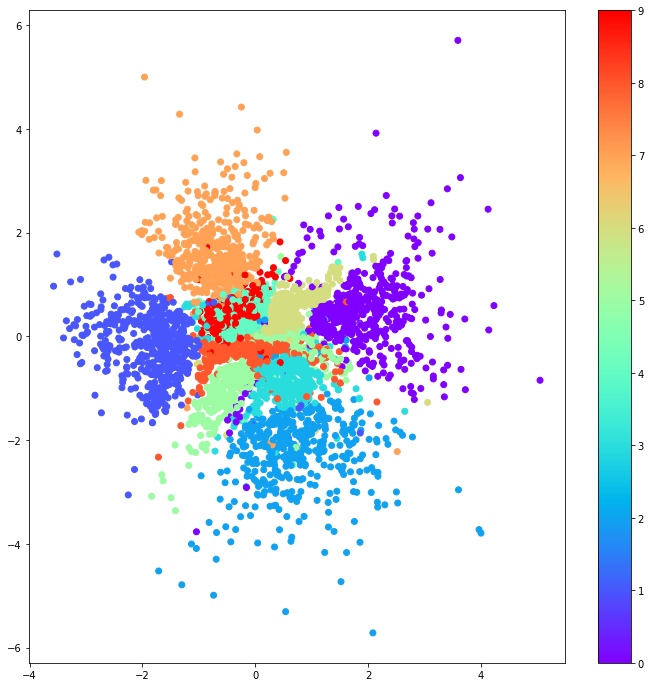

In [62]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(final_points[:, 0] , final_points[:, 1] , cmap='rainbow',c=labels)
plt.colorbar()
plt.show()

In [63]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(test_dataset)), n_to_show)

In [64]:
final_points=np.array([[0,0]])

In [65]:
labels=np.array([0])

In [66]:
for i in example_idx:
    example_images,example_labels =test_dataset[i]
    example_images=example_images.view(-1,784)
    mu,log_var = vae.encoder(example_images)
    z_points=vae.sampling(mu,log_var)
    z_points=z_points.detach().numpy()
    final_points=np.vstack((final_points,z_points))
    labels=np.vstack((labels,example_labels))

In [67]:
labels=labels.ravel()

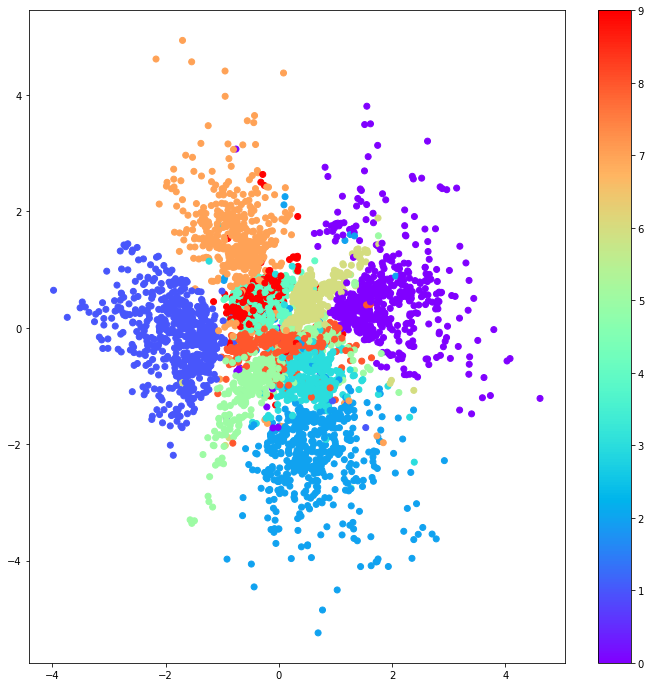

In [68]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(final_points[:, 0] , final_points[:, 1] , cmap='rainbow',c=labels)
plt.colorbar()
plt.show()